# CNN MODEL

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import os

In [11]:
class FCModel(nn.Module):
    def __init__(self, input_shape=(181, 1), num_classes=8):
        super(FCModel, self).__init__()

        self.batch_norm1 = nn.BatchNorm1d(input_shape[1])
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
        self.dropout2 = nn.Dropout(0.2)

        self.batch_norm2 = nn.BatchNorm1d(32)
        
        # Flatten layer is handled in forward()
        self.fc1 = nn.Linear(32 * input_shape[0], 512)
        self.relu_fc1 = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(512, 512)
        self.relu_fc2 = nn.ReLU()
        self.dropout_fc2 = nn.Dropout(0.2)
        self.batch_norm3 = nn.BatchNorm1d(512)

        self.fc3 = nn.Linear(512, 256)
        self.relu_fc3 = nn.ReLU()
        self.dropout_fc3 = nn.Dropout(0.1)

        self.fc_out = nn.Linear(256, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Swap dimensions to (batch, channels, sequence_length)
        
        x = self.batch_norm1(x)
        x = self.relu(self.conv1(x))
        x = self.dropout1(x)

        x = self.relu(self.conv2(x))
        x = self.dropout2(x)

        x = self.batch_norm2(x)

        x = x.view(x.size(0), -1)  # Flatten

        x = self.relu_fc1(self.fc1(x))
        x = self.dropout_fc1(x)

        x = self.relu_fc2(self.fc2(x))
        x = self.dropout_fc2(x)
        x = self.batch_norm3(x)

        x = self.relu_fc3(self.fc3(x))
        x = self.dropout_fc3(x)

        x = self.fc_out(x)
        x = self.softmax(x)

        return x

In [12]:
import os
import numpy as np

def pad_or_truncate(feature, target_length):
    """Ensures all feature vectors have the same length."""
    feature = np.array(feature)  # Ensure NumPy array
    if feature.ndim == 1:
        if len(feature) < target_length:
            feature = np.pad(feature, (0, target_length - len(feature)), mode='constant')
        else:
            feature = feature[:target_length]  # Truncate if too long
    else:
        print(f"Warning: Unexpected shape {feature.shape}")  # Debugging
    return feature

def load_features(feature_path, cnn_length=30, fuzzy_length=2):
    """Loads CNN and fuzzy features separately from files."""
    x_cnn = []
    x_fuzzy = []
    y = []
    
    for feature in sorted(os.listdir(feature_path)):  # Sort for consistency
        feat = np.loadtxt(os.path.join(feature_path, feature), delimiter=',')
        
        # Extract CNN and fuzzy features
        feat_cnn = pad_or_truncate(feat[:-2], cnn_length)  # CNN features (exclude last 2)
        feat_fuzzy = pad_or_truncate(feat[-2:], fuzzy_length)  # Fuzzy features (last 2)
        
        x_cnn.append(feat_cnn)
        x_fuzzy.append(feat_fuzzy)
        
        # Extract label safely
        try:
            label = int(feature.split('_')[-1][1])  # Adjust if needed
        except ValueError:
            continue
        y.append(label)

    # Convert to NumPy arrays
    x_cnn = np.array(x_cnn).reshape(len(x_cnn), cnn_length, 1)  # CNN-compatible
    x_fuzzy = np.array(x_fuzzy).reshape(len(x_fuzzy), fuzzy_length, 1)  # Fuzzy-compatible
    y = np.array(y).reshape(-1, 1)  # Labels

    return {"cnn":x_cnn, "fuzzy":x_fuzzy, "y":y}


# Loading features

In [ ]:
train_data = load_features('features/cnn/train')
x_train = train_data["cnn"]
Y_train = train_data["y"]

test_data = load_features('features/cnn/val')
x_val = test_data["cnn"]
y_val = test_data["y"]

print((x_train.shape,y_val.shape))

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train, dtype=torch.long).squeeze()
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).squeeze()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)

((2610, 30, 1), (1354, 1))


# Training the model
The model classifies human voices in 8 different classes of emotions

**label**   **emotion**

0   =   neutral

1   =   calm

2   =   happy

3   =   sad

4   =   angry

5   =   fearful

6   =   disgust

7   =   surprised

In [14]:
model = FCModel(input_shape=x_train_tensor[0].shape)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(150):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{150}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch 1/150, Train Loss: 2.0081, Train Acc: 28.62%, Val Loss: 2.0359, Val Acc: 39.00%
Epoch 2/150, Train Loss: 1.8396, Train Acc: 44.10%, Val Loss: 1.8283, Val Acc: 49.48%
Epoch 3/150, Train Loss: 1.7548, Train Acc: 51.15%, Val Loss: 1.6942, Val Acc: 58.20%
Epoch 4/150, Train Loss: 1.7163, Train Acc: 56.55%, Val Loss: 1.6556, Val Acc: 60.93%
Epoch 5/150, Train Loss: 1.6731, Train Acc: 61.03%, Val Loss: 1.6074, Val Acc: 67.06%
Epoch 6/150, Train Loss: 1.6400, Train Acc: 62.76%, Val Loss: 1.5839, Val Acc: 69.94%
Epoch 7/150, Train Loss: 1.6148, Train Acc: 65.90%, Val Loss: 1.5600, Val Acc: 70.97%
Epoch 8/150, Train Loss: 1.5885, Train Acc: 68.58%, Val Loss: 1.5261, Val Acc: 74.82%
Epoch 9/150, Train Loss: 1.5663, Train Acc: 72.18%, Val Loss: 1.4952, Val Acc: 78.06%
Epoch 10/150, Train Loss: 1.5363, Train Acc: 74.21%, Val Loss: 1.4857, Val Acc: 79.32%
Epoch 11/150, Train Loss: 1.5373, Train Acc: 73.98%, Val Loss: 1.4899, Val Acc: 79.47%
Epoch 12/150, Train Loss: 1.5154, Train Acc: 76.78%,

## Plots

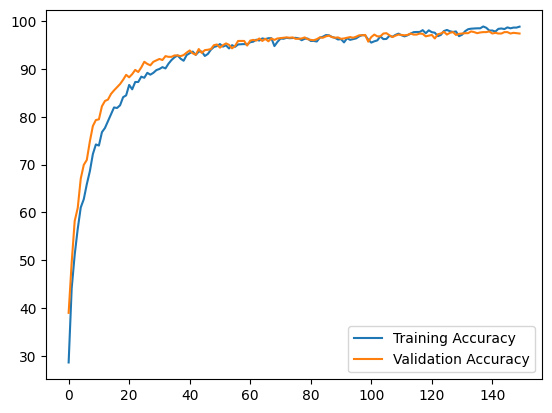

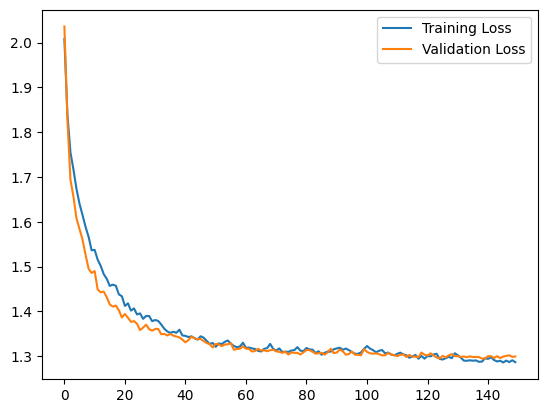

In [15]:
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [16]:
torch.save(model.state_dict(), 'cnn_model.pth')

# TEST CNN MODEL

In [17]:
model_test = FCModel(input_shape=x_train_tensor[0].shape)
model_test.load_state_dict(torch.load('cnn_model.pth'))
model_test.eval()

C:\Users\sjr00\AppData\Local\Temp\ipykernel_18368\649832415.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test.load_state_dict(torch.load('cnn_model.pth'))


FCModel(
  (batch_norm1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=same)
  (relu): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=same)
  (dropout2): Dropout(p=0.2, inplace=False)
  (batch_norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=960, out_features=512, bias=True)
  (relu_fc1): ReLU()
  (dropout_fc1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (relu_fc2): ReLU()
  (dropout_fc2): Dropout(p=0.2, inplace=False)
  (batch_norm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (relu_fc3): ReLU()
  (dropout_fc3): Dropout(p=0.1, inplace=False)
  (fc_out): Linear(in_features=256, out_features=8, bias=True)
 

In [18]:
test_data = load_features('features/cnn/test/')

x = test_data["cnn"]
y = test_data["y"]

x = torch.tensor(x, dtype=torch.float32) # Move tensor to "cuda"
y = torch.tensor(y, dtype=torch.long) 
# Create a DataLoader
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Perform inference
results = []
correct_predictions = 0  # For counting the correct predictions
with torch.no_grad():
    for batch in dataloader:
        inputs, labels = batch  # Unpack inputs and actual labels
        
        # Forward pass through the model
        outputs = model(inputs)
        
        # Get predicted class
        predictions = torch.argmax(outputs, axis=1)
        results.extend(predictions.cpu().numpy())
        
        # Compare predictions with actual labels
        
        correct_predictions += torch.sum(predictions == labels.squeeze()).item() 


accuracy = correct_predictions / len(y) * 100  # Percentage accuracy
print(f'Accuracy: {accuracy:.2f}%')
# Save the results
results = np.array(results)
np.savetxt('test_data_predictions.csv', results, delimiter=',')

print("Predictions saved to test_data_predictions.csv")


Accuracy: 91.03%
Predictions saved to test_data_predictions.csv


# Load data 

In [ ]:
train_data = load_features('features/fuzzy/train/')

x_train_cnn = train_data["cnn"]
x_train = train_data["fuzzy"]
y_train = train_data["y"]

val_data = load_features('features/fuzzy/test/')
x_val_cnn = val_data["cnn"]
x_val = val_data["fuzzy"]
y_val = val_data["y"]

# Run CNN model

In [231]:

model_cnn = FCModel(input_shape=x_train_cnn[0].shape)
model_cnn.load_state_dict(torch.load('cnn_model.pth'))
model_cnn.eval()

# Convert to tensor
x_cnn = torch.tensor(x_train_cnn, dtype=torch.float32)  # Move tensor to "cuda" if available

# Create DataLoader
dataset = TensorDataset(x_cnn)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

cnn_train_results = []

with torch.no_grad():
    for batch in dataloader:
        inputs = batch[0]  # Unpack inputs
        
        # Forward pass through the model
        outputs = model(inputs)
        
        # Get confidence scores
        confidences = torch.softmax(outputs, dim=1)

        # Get predicted class
        predictions = torch.argmax(outputs, axis=1)
        
        for pred, conf in zip(predictions.cpu().numpy(), confidences.cpu().numpy()):
            cnn_train_results.append((pred, conf.max()))  # (Predicted class, Confidence)

cnn_train_results = np.array(cnn_train_results)  # Convert to numpy array

print(cnn_train_results)

[[1.         0.27970809]
 [3.         0.27970809]
 [4.         0.27970809]
 ...
 [5.         0.27970806]
 [6.         0.27970809]
 [7.         0.27970809]]


C:\Users\sjr00\AppData\Local\Temp\ipykernel_18368\2050498879.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cnn.load_state_dict(torch.load('cnn_model.pth'))


In [232]:
# Convert to tensor
x_cnn = torch.tensor(x_val_cnn, dtype=torch.float32)  # Move tensor to "cuda" if available

# Create DataLoader
dataset = TensorDataset(x_cnn)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

cnn_val_results = []

with torch.no_grad():
    for batch in dataloader:
        inputs = batch[0]  # Unpack inputs
        
        # Forward pass through the model
        outputs = model(inputs)
        
        # Get confidence scores
        confidences = torch.softmax(outputs, dim=1)

        # Get predicted class
        predictions = torch.argmax(outputs, axis=1)
        
        for pred, conf in zip(predictions.cpu().numpy(), confidences.cpu().numpy()):
            cnn_val_results.append((pred, conf.max()))  # (Predicted class, Confidence)

cnn_val_results = np.array(cnn_val_results)  # Convert to numpy array



# FUZZY MODEL

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

def make_gauss_mfs(num_mfs):
    """
    Create Gaussian membership functions.
    :param num_mfs: Number of membership functions.
    :return: List of Gaussian membership functions.
    """
    mfs = []
    for i in range(num_mfs):
        mean = torch.rand(1) * 10  # Random mean between 0 and 10
        std = torch.rand(1) * 2 + 0.1  # Random std between 0.1 and 2.1
        mfs.append((mean, std))
    return mfs

# Define ANFIS Network
class AnfisNet(nn.Module):
    def __init__(self, input_dim, output_dim, mfs, num_rules):
        """
        Initialize the ANFIS network.
        :param input_dim: Number of input dimensions.
        :param output_dim: Number of output dimensions.
        :param mfs: List of membership functions for each input.
        """
        super(AnfisNet, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.mfs = mfs
        self.num_mfs = len(mfs)
        self.num_rules =  num_rules

        # Layer 1: Fuzzification (Gaussian Membership Functions)
        self.gauss_params = nn.ParameterList()
        for i in range(input_dim):
            for mean, std in mfs[i]:
                self.gauss_params.append(nn.Parameter(mean))
                self.gauss_params.append(nn.Parameter(std))

        # Layer 2: Rule Layer (Product of Membership Degrees)
        self.rule_weights = nn.Parameter(torch.randn(input_dim * len(mfs[0]), output_dim))

        # Layer 3: Normalization Layer
        self.norm_weights = nn.Parameter(torch.randn(input_dim * len(mfs[0]), output_dim))
   
        # Layer 4: Consequent Layer (Linear Combination)
        self.consequent_weights = nn.Parameter(torch.rand(self.num_rules, output_dim))
         

    def forward(self, x):
        """
        Forward pass of the ANFIS network.
        :param x: Input tensor of shape (batch_size, input_dim).
        :return: Output tensor of shape (batch_size, output_dim).
        """
        batch_size = x.size(0)

        # Layer 1: Fuzzification
        membership_degrees = []
        for i in range(self.input_dim):
            row = []  # Store membership values for a single input dimension
            for j, (mean, std) in enumerate(self.mfs[i]):
                gauss = torch.exp(-0.5 * ((x[:, i] - mean) / std) ** 2)
                row.append(gauss)  
            membership_degrees.append(torch.stack(row, dim=1))  # Stack along MFs for this input dim

        membership_degrees = torch.stack(membership_degrees, dim=1)  # (batch_size, input_dim, num_mfs)

        # Layer 2: Rule Layer (Product of Membership Degrees)
        rule_outputs = torch.flatten(membership_degrees, start_dim=1)  

        # Layer 3: Normalization Layer
        norm_outputs = rule_outputs / torch.sum(rule_outputs, dim=1, keepdim=True)  # (batch_size, num_mfs)

        # Layer 4: Consequent Layer (Linear Combination)
        output = torch.matmul(norm_outputs, self.consequent_weights)  # (batch_size, output_dim)

        return output

# Define FuzzyANFIS Class
class FuzzyANFIS:
    def __init__(self, input_dim, num_mfs, output_dim):
        """
        Initialize the FuzzyANFIS model.
        :param input_dim: Number of input dimensions.
        :param num_mfs: Number of membership functions per input.
        :param output_dim: Number of output dimensions.
        """
        self.input_dim = input_dim
        self.num_mfs = num_mfs
        self.output_dim = output_dim
        self.model = self.build_model()

    def build_model(self):
        """
        Build the ANFIS model.
        :return: AnfisNet instance.
        """
        mfs = []
        for _ in range(self.input_dim):
            mfs.append(make_gauss_mfs(self.num_mfs))  # Gaussian Membership Functions for each input dimension

        num_rules = self.input_dim * self.num_mfs
        return AnfisNet(self.input_dim, self.output_dim, mfs, num_rules)

    def train(self, X_train, y_train, epochs=100, lr=0.01):
        """
        Train the ANFIS model.
        :param X_train: Training input data of shape (num_samples, input_dim).
        :param y_train: Training target data of shape (num_samples, output_dim).
        :param epochs: Number of training epochs.
        :param lr: Learning rate.
        """
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        loss_function = nn.CrossEntropyLoss()
        X_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
        Y_train = torch.tensor(y_train, dtype=torch.float32, requires_grad=True)   

        for epoch in range(epochs):
            if torch.isnan(X_train).any():
                print("continue")
                continue

            optimizer.zero_grad()
            outputs = self.model(X_train)
            # 0   =   neutral, 1   =   calm, 2   =   happy, 3   =   sad, 4   =   angry, 5   =   fearful, 6   =   disgust, 7   =   surprised
            discrete_outputs = torch.round(outputs * 7).float()

            loss = loss_function(discrete_outputs, Y_train)
            
            loss.backward()
            optimizer.step()

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')


    def predict(self, X_test):
        """
        Make predictions using the trained ANFIS model.
        :param X_test: Test input data of shape (num_samples, input_dim).
        :return: Predicted output of shape (num_samples, output_dim).
        """
        with torch.no_grad():
            X_test = torch.tensor(X_test, dtype=torch.float32)
            outputs = self.model(X_test)

            discrete_outputs = torch.round(outputs * 7).float()

            return discrete_outputs.numpy()


    def save_model(self, path):
        """
        Save the trained model to a file.
        :param path: Path to save the model.
        """
        torch.save(self.model.state_dict(), path)
        print(f'Model saved to {path}')

    def load_model(self, path):
        """
        Load a trained model from a file.
        :param path: Path to load the model from.
        """
        self.model.load_state_dict(torch.load(path))
        print(f'Model loaded from {path}')

In [276]:
def prepare_fuzzy_data(x_fuzzy, cnn_results, y_train):

    if len(x_fuzzy) != len(cnn_results) or len(x_fuzzy) != len(y_train):
        raise ValueError("Lengths of x_fuzzy, cnn_results, and y_train must be the same.")

    fuzzy_data = []
    new_y_train = []  
    
    for i, sample in enumerate(x_fuzzy):
        cnn_prediction, cnn_confidence = cnn_results[i]
        
        # Convert dictionary to a list of numerical values
        data = [
            cnn_prediction,  # CNN Prediction
            cnn_confidence,  # CNN Confidence
            sample[0][0],    # Pitch
            sample[1][0]     # Energy
        ]
        
        # Check for NaN values in both fuzzy_data and y_train
        if np.any(np.isnan(data)) or np.isnan(y_train[i]):
            continue
        
        fuzzy_data.append(data)
        new_y_train.append(y_train[i])
    
    return np.array(fuzzy_data, dtype=np.float32), np.array(new_y_train, dtype=np.float32)


In [ ]:
train_data = load_features('features/fuzzy/train/')

x_train_cnn = train_data["cnn"]
x_train = train_data["fuzzy"]
y_train = train_data["y"]

val_data = load_features('features/fuzzy/test/')
x_val_cnn = val_data["cnn"]
x_val = val_data["fuzzy"]
y_val = val_data["y"]

X_train, y_train = prepare_fuzzy_data(x_train, cnn_train_results, y_train)

anfis_model = FuzzyANFIS(input_dim=4, num_mfs=6, output_dim=1)
anfis_model.train(X_train, y_train, epochs=100, lr=0.01)

Epoch 0, Loss: -0.0
Epoch 10, Loss: -0.0
Epoch 20, Loss: -0.0
Epoch 30, Loss: -0.0
Epoch 40, Loss: -0.0
Epoch 50, Loss: -0.0
Epoch 60, Loss: -0.0
Epoch 70, Loss: -0.0
Epoch 80, Loss: -0.0
Epoch 90, Loss: -0.0


In [273]:
from sklearn.metrics import accuracy_score


X_val, y_val= prepare_fuzzy_data(x_val, cnn_val_results, y_val)
predictions = anfis_model.predict(X_val)

predictions = np.round(anfis_model.predict(X_val))

# محاسبه دقت
accuracy = accuracy_score(y_val, predictions)
print(f"Accuracy: {accuracy * 100}%")

# # Save Model
# anfis_model.save_model("anfis_model.pth")

# # Load Model
# anfis_model.load_model("anfis_model.pth")

Accuracy: 11.83574879227053%
